<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Проверим-данные-на-наличие-тренда-и-сезонности" data-toc-modified-id="Проверим-данные-на-наличие-тренда-и-сезонности-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Проверим данные на наличие тренда и сезонности</a></span></li><li><span><a href="#Проверим-временной-ряд-на-стационарность" data-toc-modified-id="Проверим-временной-ряд-на-стационарность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Проверим временной ряд на стационарность</a></span><ul class="toc-item"><li><span><a href="#Скользящие-средние" data-toc-modified-id="Скользящие-средние-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Скользящие средние</a></span></li><li><span><a href="#Тест-Дики-Фуллера" data-toc-modified-id="Тест-Дики-Фуллера-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Тест Дики-Фуллера</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Градиентный бустинг</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [13]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.stattools import adfuller

In [14]:
warnings.filterwarnings('ignore')

Загрузим данные, изменим тип данных поля datetime и установим его в качестве индекса (тип поля должен быть DatetimeIndex) 

In [15]:
taxi_data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [17]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [18]:
type(taxi_data.index)

pandas.core.indexes.datetimes.DatetimeIndex

## Анализ

Проверим, что наш индекс монотонно возрастает

In [19]:
if taxi_data.index.is_monotonic:
    print('Данные временного ряда монотонны.')

Данные временного ряда монотонны.


Проведем ресемплирование временного ряда

In [20]:
taxi = taxi_data.resample('1H').sum()

Рассмотрим график заказов всего временного ряда

In [21]:
fig_size = (16,5)

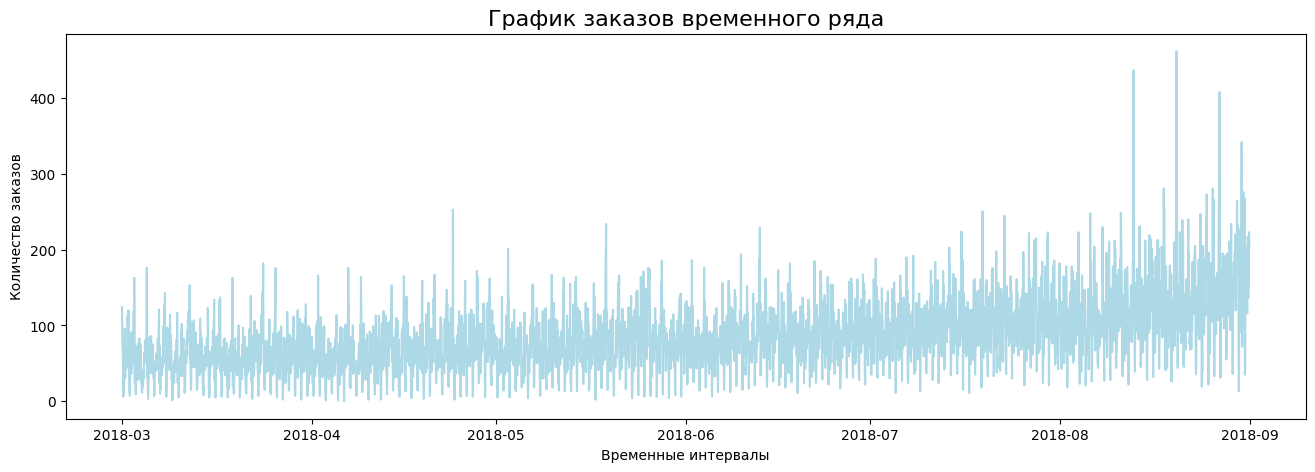

In [22]:
plt.figure(figsize=fig_size)
plt.title('График заказов временного ряда', fontsize=16)
plt.xlabel("Временные интервалы")
plt.ylabel("Количество заказов")
plt.plot( taxi.index, 'num_orders', data=taxi, color='lightblue')
plt.show()

Данный ряд не стационарен, так как со временем растет среднее значение, значит скорее всего есть общий восходящий тренд.

### Проверим данные на наличие тренда и сезонности

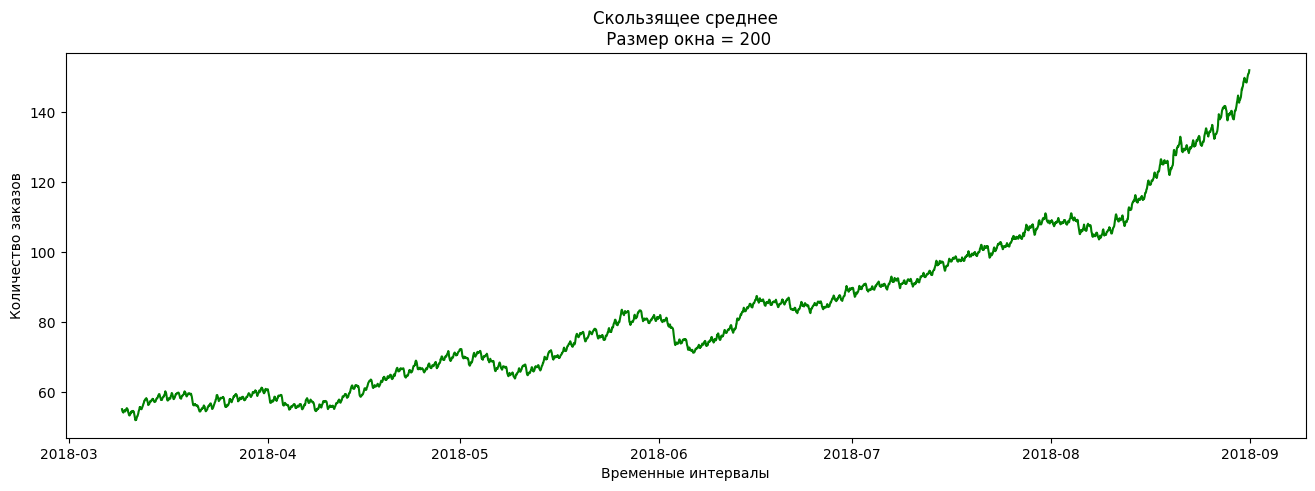

In [23]:
n = 200
rolling_mean = taxi.rolling(window=n,closed='left').mean()
plt.figure(figsize=fig_size)
plt.xlabel("Временные интервалы")
plt.ylabel("Количество заказов")
plt.title("Скользящее среднее\n Размер окна = {}".format(n))
plt.plot(rolling_mean, "g", label="Rolling mean trend");

- Явно выражен восходящий тренд
- На графике есть периодические колебания, которые могут быть сезонностью

Рассмотрим наличие сезонности

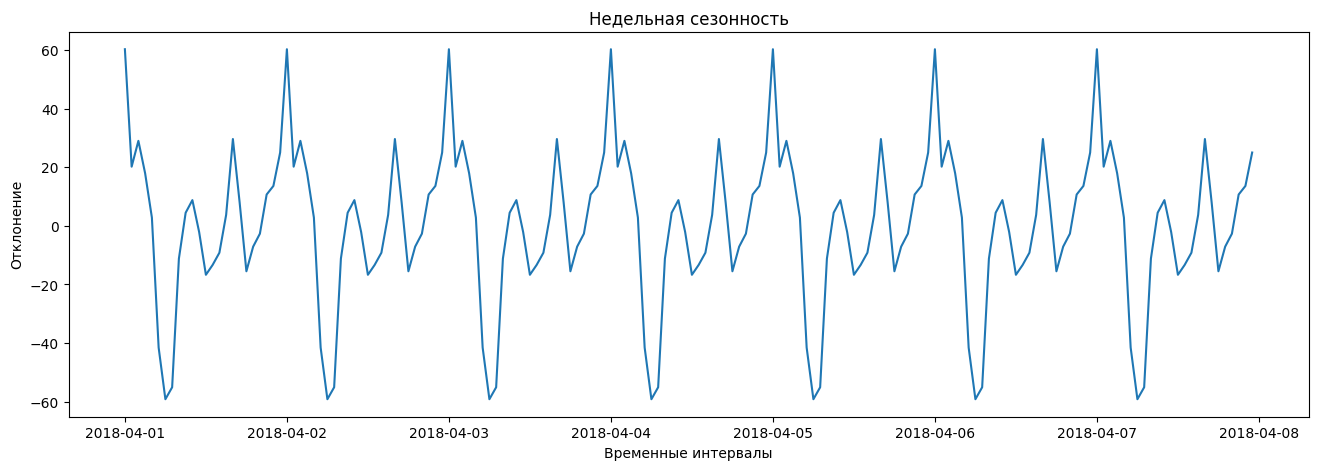

In [24]:
decomposed = seasonal_decompose(taxi)
fig = decomposed.seasonal['2018-04-01':'2018-04-07']
plt.figure(figsize=fig_size)
plt.xlabel("Временные интервалы")
plt.ylabel("Отклонение")
plt.title("Недельная сезонность")
plt.plot(fig);

Сезонность явно есть. Рассмотрим более мелкий диапазон.

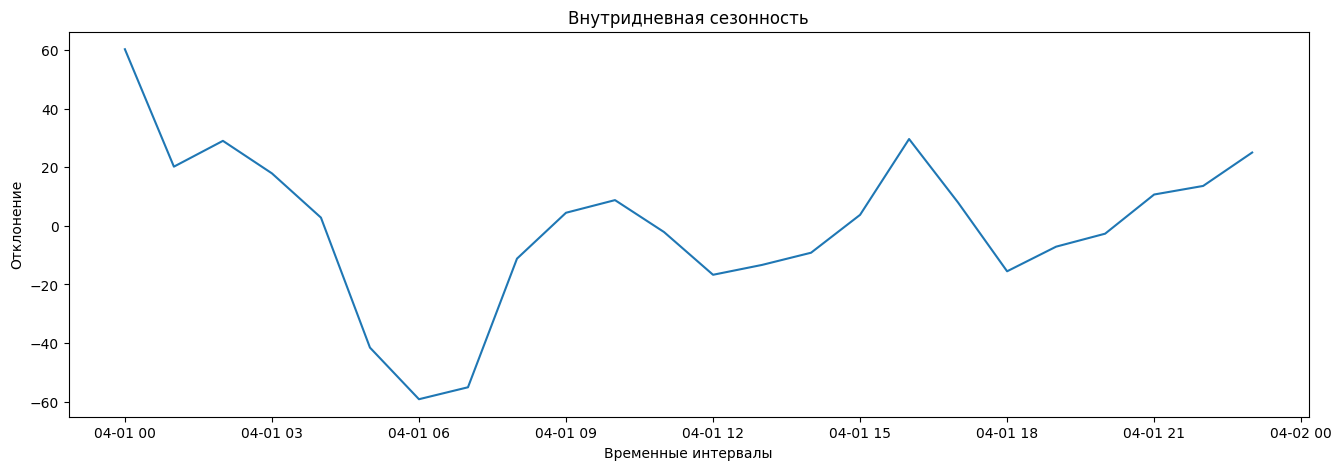

In [25]:
fig = decomposed.seasonal['2018-04-01':'2018-04-01']
plt.figure(figsize=fig_size)
plt.xlabel("Временные интервалы")
plt.ylabel("Отклонение")
plt.title("Внутридневная сезонность")
plt.plot(fig);

- Втечение дня с 00:00 до 06:00 наблюдается падение количества заказов
- С 06:00 до 00:00 рост количества заказов
- Такое распределение заказов говорит о том что к вечеру/ночи количество рейсов сильно увеличивается, что способстует увеличению количества заказов такси

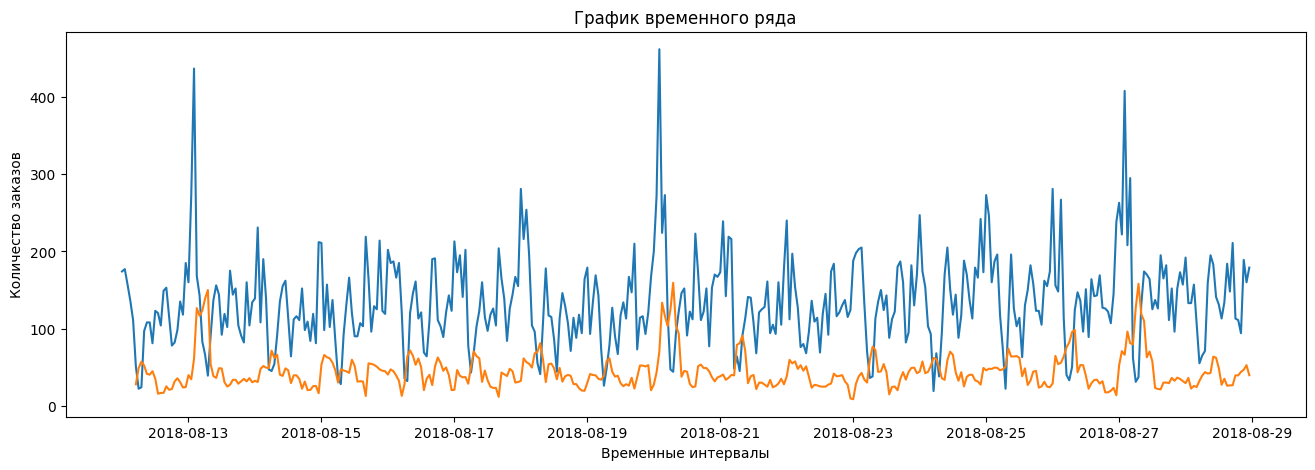

In [29]:
day = taxi_data['2018-08-12':'2018-08-28'].resample('1H').sum()
day['std'] = day['num_orders'].rolling(5,closed='left').std()
plt.figure(figsize=fig_size)
plt.xlabel("Временные интервалы")
plt.ylabel("Количество заказов")
plt.title("График временного ряда")
plt.plot(day)
plt.show();

Так же наблюдается всплески заказов на выходных

### Проверим временной ряд на стационарность

#### Скользящие средние

<Figure size 1600x500 with 0 Axes>

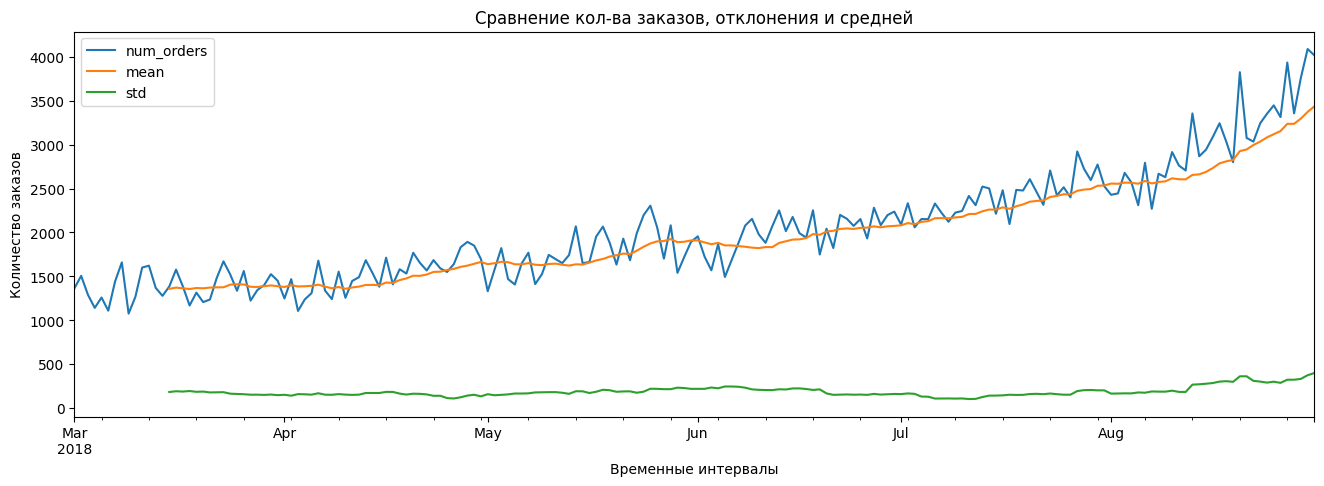

In [30]:
taxi_1 = taxi_data.resample('1D').sum()
taxi_1['mean'] = taxi_1['num_orders'].rolling(15).mean()
taxi_1['std'] = taxi_1['num_orders'].rolling(15).std()
plt.figure(figsize=fig_size)
taxi_1.plot(figsize=fig_size,
            xlabel='Временные интервалы',
            ylabel='Количество заказов',
            title='Сравнение кол-ва заказов, отклонения и средней');

Видим что скользящая средняя растет быстрее, чем скользящее стандартное отклонение - **ряд нестационарный**

#### Тест Дики-Фуллера

Выдвигаем нулевую гепотизу "Ряд стационарен по критерию Дики-Фуллера" и проверяем на истинность.

In [31]:
alpha = [0.01,0.05]
p_value = adfuller(taxi['num_orders'])[1]
print('p_value =', p_value)
print()
for a in alpha:
    print(f"При alpha = {a}")
    if p_value < a:
        print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
    else:
        print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера')
    print()

p_value = 0.028940051402612965

При alpha = 0.01
Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера

При alpha = 0.05
Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера



Так как скользящие средние говорят о нестационарности ряда и тест Дики-Фуллера при `alpha = 1%` это подтверждает, делаем вывод, что ряд нестационарный.

Выводы
- В данных наблюдается дневная сезонность (пик ночью, спад утром)
- Такое распределение заказов говорит о том что к вечеру/ночи количество рейсов сильно увеличивается, что способстует увеличению количества заказов такси
- На графиках присутствует недельная сезонность (воскресенье есть пик заказов)
- Есть явно выраженный восходящий тренд
- Проверка ряда на стационарность скользящими средними и тестом Дики-Фулера показала, что ряд нестационарный.

## Обучение

In [32]:
def make_features(data, max_lag, rolling_mean_size):
    
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['weekday'] = data.index.weekday
    data['hour'] = data.index.hour
    data['is_weekend'] = data.weekday.isin([5,6])*1
    data['is_morning'] = data.hour.isin(range(5,11))*1
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    data = data.dropna()
    
    features = data.drop(['num_orders'], axis = 1)
    target = data['num_orders']
    
    features_train, features_test, target_train, target_test = train_test_split(features,  target,
                                                                                  shuffle=False, test_size=0.1)
    
    return features, target, features_train, features_test, target_train, target_test

In [33]:
features, target, features_train, features_test, target_train, target_test = make_features(taxi, 100, 5)

### Линейная регрессия

In [34]:
regressor = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)
cv_RMSE_LR = (cross_val_score(regressor, 
                             features_train, 
                             target_train, 
                             cv=tscv, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Средний показатель RMSE при кросс-валидации для модели LinearRegression =', cv_RMSE_LR)

Средний показатель RMSE при кросс-валидации для модели LinearRegression = 23.983985805263185


### Градиентный бустинг

In [35]:
gradient = GradientBoostingRegressor(random_state=12345)
tscv = TimeSeriesSplit(n_splits=5)
cv_RMSE_BGR = (cross_val_score(gradient, 
                             features_train, 
                             target_train, 
                             cv=tscv, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Средний показатель RMSE при кросс-валидации для модели GradientBoostingRegressor =', cv_RMSE_BGR)

Средний показатель RMSE при кросс-валидации для модели GradientBoostingRegressor = 24.308629192674363


### XGBoost

Подберем параметры

In [36]:
xgb_reg =  xgb.XGBRegressor(random_state=12345,verbosity=0, silent=1) 
tscv = TimeSeriesSplit(n_splits=5)
hyperparams = [{'max_depth':[2,4,6,8,10], 
                'learning_rate':[0.1,0.3,0.5],
                'n_estimators':[100,200]}]

clf = GridSearchCV(xgb_reg, hyperparams, cv=tscv, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, imp...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=12345, ...),
             param_grid=[{'learning_rate': [0.1, 0.3, 0.5],
                          'max_depth': [2, 4, 6, 8, 10],
                          'n_estimators': [100, 200]}],
             scoring='neg_mean_squared_error')

In [37]:
clf.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

Обучим модель с оптимальными параметрами

In [38]:
xgb_reg =  xgb.XGBRegressor(random_state=12345,
                            verbosity=0,
                            silent=1,
                            learning_rate=0.1,
                            max_depth=4,
                            n_estimators=100) 

cv_RMSE_XGBR = (cross_val_score(xgb_reg,
                                features_train, 
                                target_train, 
                                cv=tscv, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5

print('Средний показатель RMSE при кросс-валидации и масштабировании для модели XGBRegressor =', cv_RMSE_XGBR)

Средний показатель RMSE при кросс-валидации и масштабировании для модели XGBRegressor = 24.040640126709246


### CatBoost

Подберем параметры

In [39]:
cbr = CatBoostRegressor(random_state=12345, verbose=False)
tscv = TimeSeriesSplit(n_splits=5)
hyperparams = [{'learning_rate':[0.3,0.5],
                'iterations':[100,200],
                'depth':[2,4,6,8,10]}]

clf = GridSearchCV(cbr, hyperparams, cv=tscv, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001B493B2CB10>,
             param_grid=[{'depth': [2, 4, 6, 8, 10], 'iterations': [100, 200],
                          'learning_rate': [0.3, 0.5]}],
             scoring='neg_mean_squared_error')

In [40]:
clf.best_params_

{'depth': 4, 'iterations': 100, 'learning_rate': 0.3}

Обучим модель с оптимальными параметрами

In [43]:
cbr = CatBoostRegressor(learning_rate=0.3,
                              iterations=200,
                              depth=4,
                              random_state=12345, 
                              verbose=False,) 

cv_RMSE_CBR = (cross_val_score(cbr,
                                features_train, 
                                target_train, 
                                cv=tscv, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5

print('Средний показатель RMSE при кросс-валидации и масштабировании для модели CatBoostRegressor =', cv_RMSE_CBR)

Средний показатель RMSE при кросс-валидации и масштабировании для модели CatBoostRegressor = 25.08393150488797


Лучший результат на обучающей выборке показала модель `LinearRegression`\
Данную модель и будем оценивать на тестовой выборке.

## Тестирование

Фукнция отрисовки графиков предсказаний и значений целевого признака

In [98]:
def plot_compare(predictions_model):
    predictions = pd.DataFrame(predictions_model)
    predictions.index = target_test.index
    predictions['target_test'] = target_test
    plt.figure(figsize=fig_size)
    plt.xlabel("График временного ряда")
    plt.ylabel("Количество заказов")
    plt.plot(predictions)
    plt.show();

### Линейная регрессия

In [99]:
model = LinearRegression()
model.fit(features_train,target_train)
pred = model.predict(features_test)
print('RMSE модели: ', mean_squared_error(target_test, pred)**0.5)

RMSE модели:  39.686213017837304


Построим график, где сопоставим распределение целевого признака и предсказаний

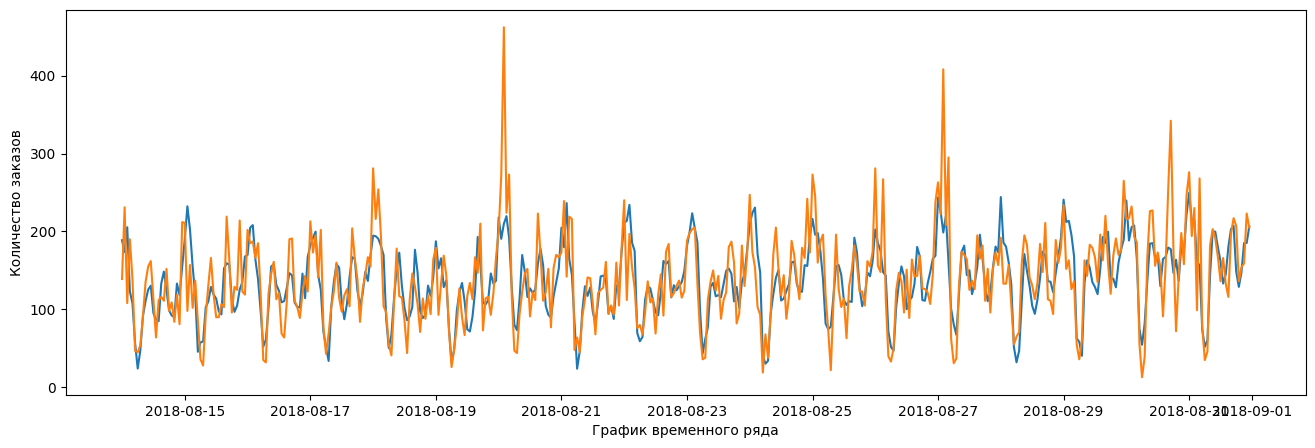

In [100]:
plot_compare(pred)

Как видим из графика нибольшее отклонение предсказания от значений целевого признака при резких скачках (рост/падение) и ближе к концу августа - то есть в моменты, когда ряд наиболее нестационарен.

Проверим качество константной модели и сравним с отобранной

In [101]:
dum = DummyRegressor()
dum.fit(features_train,target_train)
pred = dum.predict(features_test)
print('RMSE модели: ', mean_squared_error(target_test, pred)**0.5)

RMSE модели:  84.80942472748956


Видим что качество константной модели во много раз уступает качеству выбранной модели

### Вывод

Анализ данных:
- В данных наблюдается дневная сезонность (пик ночью, спад утром)
    - Втечение дня с 00:00 до 06:00 наблюдается падение количества заказов
    - С 06:00 до 00:00 рост количества заказов
    - Такое распределение заказов говорит о том что к вечеру/ночи количество рейсов сильно увеличивается, что способстует увеличению количества заказов такси
- На графиках присутствует недельная сезонность (воскресенье есть пик заказов)
- Есть явно выраженный восходящий тренд
- Проверка ряда на стационарность скользящими средними и тестом Дики-Фулера показала, что ряд нестационарный.

Обучение моделей:
- Из всех обученных моделей лучшее качяество на тестовых данных показала модель `LinearRegression`
- Наибольшее отклонение предсказания от значений целевого признака при резких скачках (рост/падение) и ближе к концу августа - то есть в моменты, когда ряд наиболее нестационарен.
- Сравнение качества выбранной модели с качеством константной модели показал преимущество выбранной модели
